In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from joblib import Parallel, delayed

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/flood.csv'
df = pd.read_csv(file_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
0,3,8,6,6,4,4,6,2,3,2,...,10,7,4,2,3,4,3,2,6,0.450
1,8,4,5,7,7,9,1,5,5,4,...,9,2,6,2,1,1,9,1,3,0.475
2,3,10,4,1,7,5,4,7,4,9,...,7,4,4,8,6,1,8,3,6,0.515
3,4,4,2,7,3,4,1,4,6,4,...,4,2,6,6,8,8,6,6,10,0.520
4,3,7,5,2,5,8,5,2,7,5,...,7,6,5,3,3,4,4,3,4,0.475


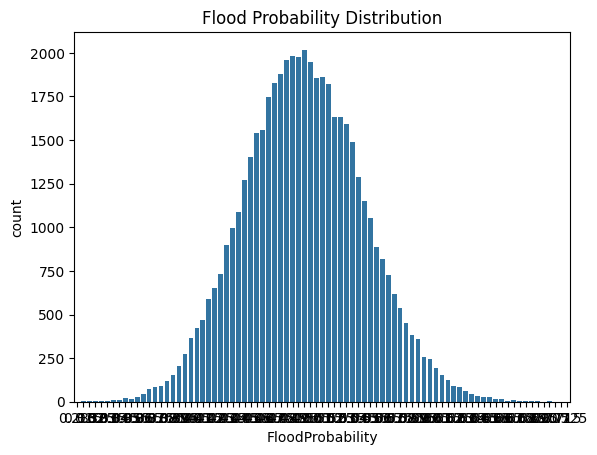

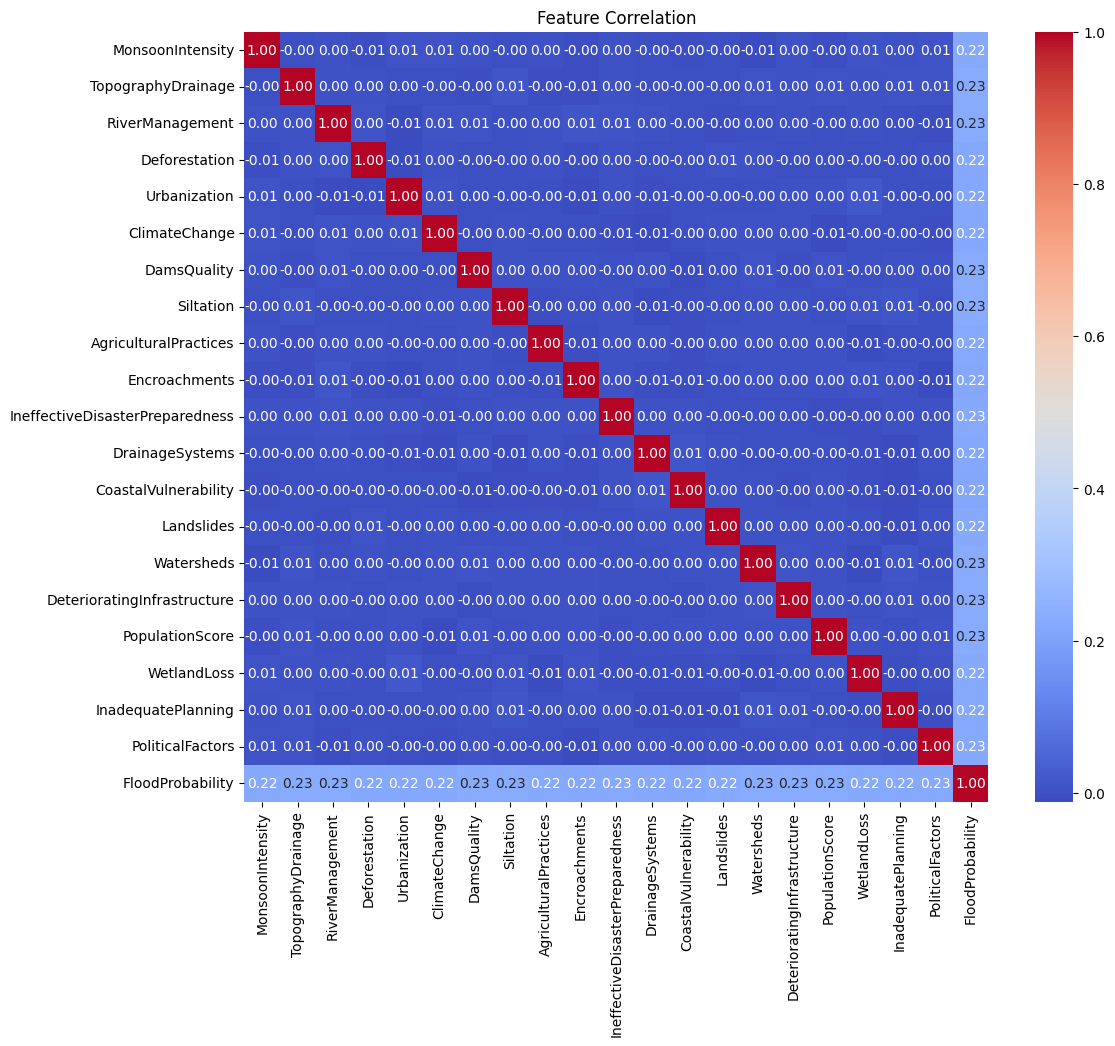

In [ ]:
#Exploratory Data Analysis (EDA)
# Class distribution
sns.countplot(x='FloodProbability', data=df)
plt.title('Flood Probability Distribution')
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation')
plt.show()

In [ ]:
# Data Preprocessing
# Separate features and target
X = df.drop('FloodProbability', axis=1)
y = df['FloodProbability']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    random_state=42,
    stratify=None
)

In [ ]:
# Train Multiple Models (REGRESSION)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Function to train a model
def train_model(name, model, X_train, y_train):
    model.fit(X_train, y_train)
    return name, model

# Parallel training
results = Parallel(n_jobs=-1)(
    delayed(train_model)(name, model, X_train, y_train)
    for name, model in models.items()
)

trained_models = dict(results)
print("Models trained successfully:", list(trained_models.keys()))

Models trained successfully: ['Linear Regression', 'Ridge Regression', 'Decision Tree', 'SVM', 'Random Forest']



=== Linear Regression ===
Cross-Validated RMSE: 8.660407660998637e-17
Test MSE: 8.918134163281759e-33
Test MAE: 6.958322806838169e-17
Test R²: 1.0


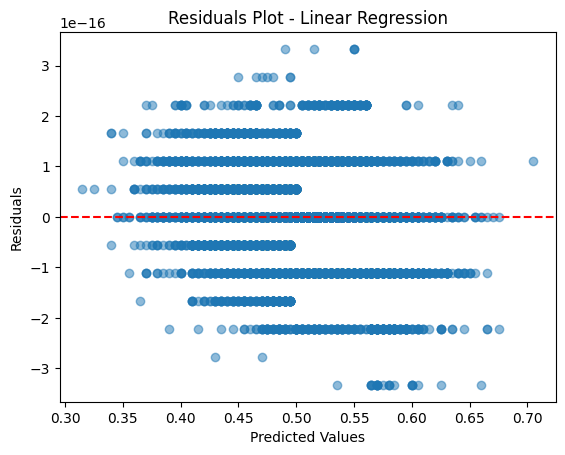


=== Ridge Regression ===
Cross-Validated RMSE: 1.5612800740812814e-06
Test MSE: 1.5507594670531105e-12
Test MAE: 9.939810980313823e-07
Test R²: 0.9999999993773515


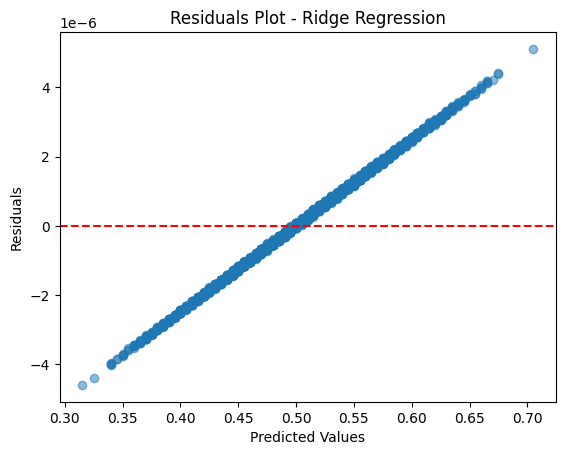


=== Decision Tree ===
Cross-Validated RMSE: 0.046968159372892934
Test MSE: 0.0022153925000000002
Test MAE: 0.0373135
Test R²: 0.11049338270749498


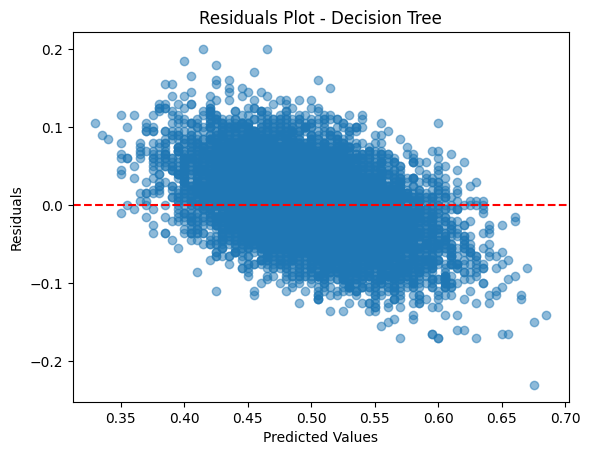


=== SVM ===
Cross-Validated RMSE: 0.02744609181644972
Test MSE: 0.0006984723204456066
Test MAE: 0.02017997846380282
Test R²: 0.7195549993818169


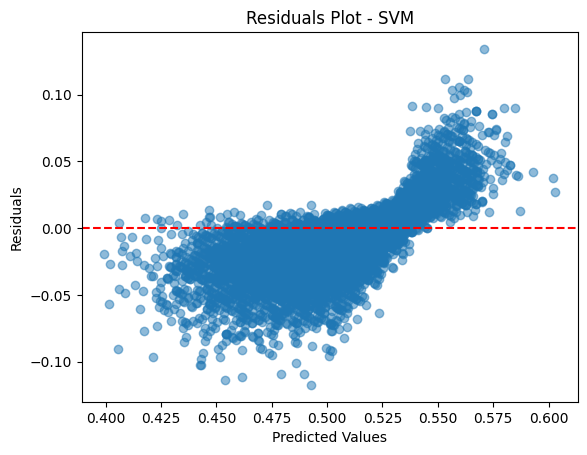


=== Random Forest ===
Cross-Validated RMSE: 0.02615310636653003
Test MSE: 0.0006711209520000005
Test MAE: 0.02047456000000001
Test R²: 0.7305369013357019


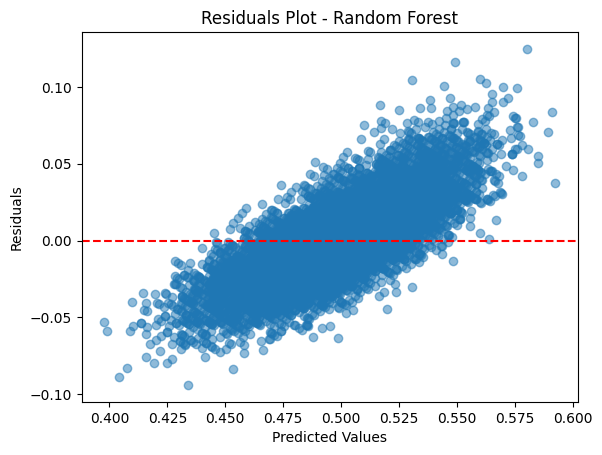

In [35]:
# Evaluate Models (REGRESSION)
for name, model in trained_models.items():
    print(f"\n=== {name} ===")

    # Cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    print("Cross-Validated RMSE:", -scores.mean())  # Convert back to positive

    # Test predictions
    preds = model.predict(X_test)

    # Regression metrics
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    print("Test MSE:", mse)
    print("Test MAE:", mae)
    print("Test R²:", r2)

    # Residual plot
    residuals = y_test - preds
    plt.scatter(preds, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals Plot - {name}')
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

In [41]:
# Save Best Model
if 'trained_models' in locals() and len(trained_models) > 0:
    try:
        # Check if metrics exist in any form
        if 'metrics_df' in locals() and not metrics_df.empty:
            best_model_name = metrics_df.loc[metrics_df['Test R²'].idxmax(), 'Model']
        else:
            # Fallback: Just save the first model if no metrics exist
            best_model_name = list(trained_models.keys())[0]

        best_model = trained_models[best_model_name]
        joblib.dump(best_model, 'best_flood_prediction_model.pkl')
        print(f"\n💾 Model saved: '{best_model_name}' as 'best_flood_prediction_model.pkl'")

    except Exception as e:
        print(f"\n⚠️ Couldn't save model: {str(e)}")
else:
    print("\n⏩ Run model training first to enable saving")


💾 Model saved: 'Linear Regression' as 'best_flood_prediction_model.pkl'
